# Whole Slide Image Classification Using PyTorch and TIAToolbox


## Introduction

In this tutorial, we will show how to classify Whole Slide Images (WSIs) using PyTorch deep learning models with help from TIAToolbox. A WSI represents human tissues taken through an operation or a biopsy and scanned using specialized scanners. They are used by pathologists and computational pathology researchers to [study cancer at the microscopic level](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7522141/) in order to understand for example tumor growth and help improve treatment for patients.

What makes WSIs challenging to process is their enormous size. For example, a typical slide image has in the order of [100,000x100,000 pixels](https://doi.org/10.1117%2F12.912388) where each pixel can correspond to about 0.25x0.25 microns on the slide. This introduces challenges in loading and processing such images, not to mention hundreds or even thousands of WSIs in a single study (larger studies produce better results)!

Conventional image processing pipelines are not suitable for WSI processing so we need better tools. This where [TIAToolbox](https://github.com/TissueImageAnalytics/tiatoolbox) can help as it brings a set of useful tools to import and process tissue slides in a fast and computationally efficient manner. Typically, WSIs are saved in a pyramid structure with multiple copies of the same image at various magnification levels optimized for visualization. The level 0 (or the bottom level) of the pyramid contains the image at the highest magnification or zoom level, whereas the higher levels in the pyramid have a lower resolution copy of the base image. The pyramid structure is sketched below.

![WSI pyramid stack](https://tia-toolbox.readthedocs.io/en/latest/_images/read_bounds_tissue.png)
*WSI pyramid stack ([source](https://tia-toolbox.readthedocs.io/en/latest/_autosummary/tiatoolbox.wsicore.wsireader.WSIReader.html#))*

<br/>

TIAToolbox allows us to automate common downstream analysis tasks such as [tissue classification](https://doi.org/10.1016/j.media.2022.102685). In this tutorial we will show you how you can:
1. Load WSI images using TIAToolbox; and
2. Use different PyTorch models to classify slides at the batch-level. In this tutorial, we will provide an example of using TorchVision's `ResNet18` model and custom [`HistoEncoder`](https://github.com/jopo666/HistoEncoder) model.

Let's get started!

## Setting up the environment
To run the examples provided in this tutorial, the following packages are required as prequisites..

1. OpenJpeg
2. OpenSlide
3. Pixman
4. TIAToolbox
5. HistoEncoder (for a custom model example)

Please run the following command in your terminal to install these packages:

In [ ]:
%%bash
apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools libpixman-1-dev | tail -n 1
pip install histoencoder | tail -n 1
pip install git+https://github.com/TissueImageAnalytics/tiatoolbox.git@develop | tail -n 1
echo "Installation is done."

Alternatively, you can run `brew install openjpeg openslide` to install the prerequistite packages on MacOS instead of `apt-get`. Further information on installation can be [found here](https://tia-toolbox.readthedocs.io/en/latest/installation.html). You will likely need to restart the runtime in the runtime menu at the top of the page to continue with the rest of the tutorial, in order for the newly installed dependencies to be picked up.

### Importing related libraries



In [ ]:
"""Import modules required to run the Jupyter notebook."""
from __future__ import annotations

# Configure logging
import logging
import warnings
if logging.getLogger().hasHandlers():
    logging.getLogger().handlers.clear()
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

# Downloading data and files
import shutil
from pathlib import Path
from zipfile import ZipFile

# Data processing and visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
import PIL
import contextlib
import io
from sklearn.metrics import accuracy_score, confusion_matrix

# TIAToolbox for WSI loading and processing
from tiatoolbox import logger
from tiatoolbox.models.architecture import vanilla
from tiatoolbox.models.engine.patch_predictor import (
    IOPatchPredictorConfig,
    PatchPredictor,
)
from tiatoolbox.utils.misc import download_data, grab_files_from_dir
from tiatoolbox.utils.visualization import overlay_prediction_mask
from tiatoolbox.wsicore.wsireader import WSIReader

# Torch-related
import torch
from torchvision import transforms

# Configure plotting
mpl.rcParams["figure.dpi"] = 160  # for high resolution figure in notebook
mpl.rcParams["figure.facecolor"] = "white"  # To make sure text is visible in dark mode

# If you are not using GPU, change ON_GPU to False
ON_GPU = True

# Function to suppress console output for overly verbose code blocks
def suppress_console_output():
    return contextlib.redirect_stderr(io.StringIO())

### Clean-up before a run

To ensure proper clean-up (for example in abnormal termination), all files downloaded or created in this run are saved in a single directory `global_save_dir`, which we set equal to "./tmp/". To simplify maintenance, the name of the directory occurs only at this one place, so that it can easily be changed, if desired.



In [ ]:
warnings.filterwarnings("ignore")
global_save_dir = Path("./tmp/")


def rmdir(dir_path: str | Path) -> None:
    """Helper function to delete directory."""
    if Path(dir_path).is_dir():
        shutil.rmtree(dir_path)
        logger.info("Removing directory %s", dir_path)


rmdir(global_save_dir)  # remove  directory if it exists from previous runs
global_save_dir.mkdir()
logger.info("Creating new directory %s", global_save_dir)

|2023-11-12|17:47:11.792| [INFO] Removing directory tmp
|2023-11-12|17:47:11.792| [INFO] Creating new directory tmp


### Downloading the data
For our sample data, we will use one whole-slide image, and patches from the validation subset of [Kather 100k](https://zenodo.org/record/1214456#.YJ-tn3mSkuU) dataset.


In [ ]:
wsi_path = global_save_dir / "sample_wsi.svs"
patches_path = global_save_dir / "kather100k-validation-sample.zip"
weights_path = global_save_dir / "resnet18-kather100k.pth"

logger.info("Download has started. Please wait...")

# Downloading and unzip a sample whole-slide image
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/sample_wsis/TCGA-3L-AA1B-01Z-00-DX1.8923A151-A690-40B7-9E5A-FCBEDFC2394F.svs",
    wsi_path,
)

# Download and unzip a sample of the validation set used to train the Kather 100K dataset
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/datasets/kather100k-validation-sample.zip",
    patches_path,
)
with ZipFile(patches_path, "r") as zipfile:
    zipfile.extractall(path=global_save_dir)

# Download pretrained model weights for WSI classification using ResNet18 architecture
download_data(
    "https://tiatoolbox.dcs.warwick.ac.uk/models/pc/resnet18-kather100k.pth",
    weights_path,
)

logger.info("Download is complete.")

|2023-11-12|17:47:11.797| [INFO] Download has started. Please wait...
|2023-11-12|17:47:28.245| [INFO] Download is complete.


## Reading the data

We create a list of patches and a list of corresponding labels.
For example, the first label in `label_list` will indicate the class of the first image patch in `patch_list`.



|2023-11-12|17:47:28.276| [INFO] Class ID: 0 -- Class Name: BACK -- Number of images: 211
|2023-11-12|17:47:28.276| [INFO] Class ID: 1 -- Class Name: NORM -- Number of images: 176
|2023-11-12|17:47:28.277| [INFO] Class ID: 2 -- Class Name: DEB -- Number of images: 230
|2023-11-12|17:47:28.277| [INFO] Class ID: 3 -- Class Name: TUM -- Number of images: 286
|2023-11-12|17:47:28.277| [INFO] Class ID: 4 -- Class Name: ADI -- Number of images: 208
|2023-11-12|17:47:28.277| [INFO] Class ID: 5 -- Class Name: MUC -- Number of images: 178
|2023-11-12|17:47:28.277| [INFO] Class ID: 6 -- Class Name: MUS -- Number of images: 270
|2023-11-12|17:47:28.278| [INFO] Class ID: 7 -- Class Name: STR -- Number of images: 209
|2023-11-12|17:47:28.278| [INFO] Class ID: 8 -- Class Name: LYM -- Number of images: 232
|2023-11-12|17:47:28.278| [INFO] Total number of patches: 2000


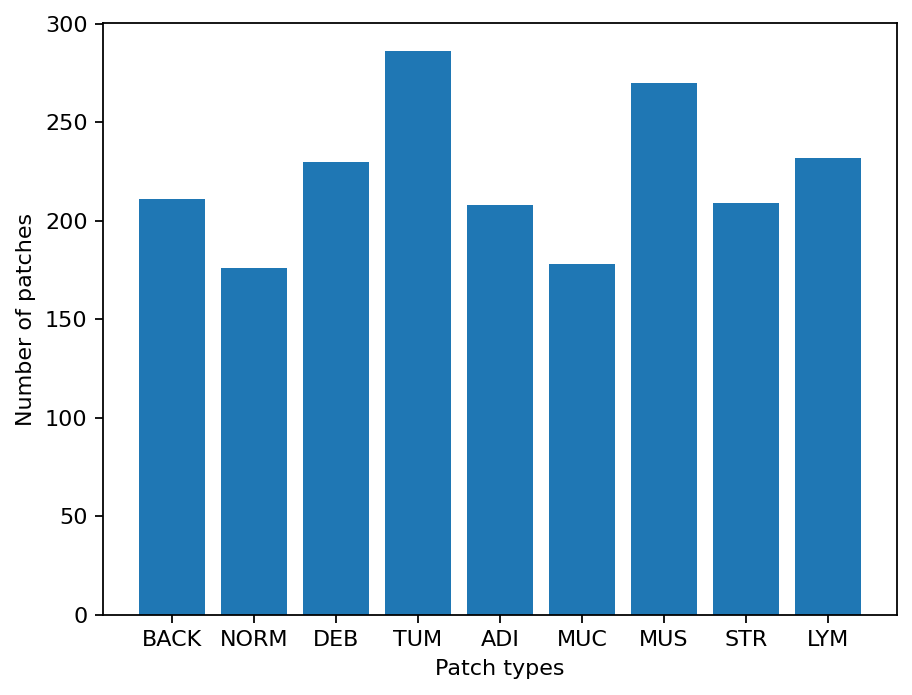

In [ ]:
# Read the patch data and create a list of patches and a list of corresponding labels
dataset_path = global_save_dir / "kather100k-validation-sample"

# Set the path to the dataset
image_ext = ".tif"  # file extension of each image

# Obtain the mapping between the label ID and the class name
label_dict = {
    "BACK": 0, # Background (empty glass region)
    "NORM": 1, # Normal colon mucosa
    "DEB": 2,  # Debris
    "TUM": 3,  # Colorectal adenocarcinoma epithelium
    "ADI": 4,  # Adipose
    "MUC": 5,  # Mucus
    "MUS": 6,  # Smooth muscle
    "STR": 7,  # Cancer-associated stroma
    "LYM": 8,  # Lymphocytes
}

class_names = list(label_dict.keys())
class_labels = list(label_dict.values())

# Generate a list of patches and generate the label from the filename
patch_list = []
label_list = []
for class_name, label in label_dict.items():
    dataset_class_path = dataset_path / class_name
    patch_list_single_class = grab_files_from_dir(
        dataset_class_path,
        file_types="*" + image_ext,
    )
    patch_list.extend(patch_list_single_class)
    label_list.extend([label] * len(patch_list_single_class))

# Show some dataset statistics
plt.bar(class_names, [label_list.count(label) for label in class_labels])
plt.xlabel("Patch types")
plt.ylabel("Number of patches")

# Count the number of examples per class
for class_name, label in label_dict.items():
    logger.info(
        "Class ID: %d -- Class Name: %s -- Number of images: %d",
        label,
        class_name,
        label_list.count(label),
    )

# Overall dataset statistics
logger.info("Total number of patches: %d", (len(patch_list)))

As you can see for this patch dataset, we have 9 classes/labels with IDs 0-8 and associated class names. describing the dominant tissue type in the patch:

- BACK ⟶ Background (empty glass region)
- LYM  ⟶ Lymphocytes
- NORM ⟶ Normal colon mucosa
- DEB  ⟶ Debris
- MUS  ⟶ Smooth muscle
- STR  ⟶ Cancer-associated stroma
- ADI  ⟶ Adipose
- MUC  ⟶ Mucus
- TUM  ⟶ Colorectal adenocarcinoma epithelium



## Classify image patches

We demonstrate how to obtain a prediction for each patch within a digital slide first with the `patch` mode and then with a large slide using `wsi` mode.

### Define `PatchPredictor` model

The PatchPredictor class runs a CNN-based classifier written in PyTorch.

- `model` can be any trained PyTorch model with the constraint that it should follow the [`tiatoolbox.models.abc.ModelABC`](https://tia-toolbox.readthedocs.io/en/latest/_autosummary/tiatoolbox.models.models_abc.ModelABC.html) class structure. For more information on this matter, please refer to [our example notebook on advanced model techniques](https://github.com/TissueImageAnalytics/tiatoolbox/blob/develop/examples/07-advanced-modeling.ipynb). In order to load a custom model, you need to write a small preprocessing function, as in `preproc_func(img)`, which make sures the input tensors are in the right format for the loaded network.
- Alternatively, you can pass `pretrained_model` as a string argument. This specifies the CNN model that performs the prediction, and it must be one of the models listed [here](https://tia-toolbox.readthedocs.io/en/latest/usage.html?highlight=pretrained%20models#tiatoolbox.models.architecture.get_pretrained_model). The command will look like this: `predictor = PatchPredictor(pretrained_model='resnet18-kather100k', pretrained_weights=weights_path, batch_size=32)`.
- `pretrained_weights`: When using a `pretrained_model`, the corresponding pretrained weights will also be downloaded by default.  You can override the default with your own set of weights via the `pretrained_weight` argument.
- `batch_size`: Number of images fed into the model each time. Higher values for this parameter require a larger (GPU) memory capacity.

In [ ]:
model = vanilla.CNNModel(backbone="resnet18", num_classes=9) # Importing model from torchvision.models.resnet18
model.load_state_dict(torch.load(weights_path, map_location="cpu"), strict=True)
def preproc_func(img):
    img = PIL.Image.fromarray(img)
    img = transforms.ToTensor()(img)
    return img.permute(1, 2, 0)
model.preproc_func = preproc_func
predictor = PatchPredictor(model=model, batch_size=32)

### Predict patch labels

We create a predictor object and then call the `predict` method using the `patch` mode. We then compute the classification accuracy and confusion matrix.

In [ ]:
with suppress_console_output():
    output = predictor.predict(imgs=patch_list, mode="patch", on_gpu=ON_GPU)

acc = accuracy_score(label_list, output["predictions"])
logger.info("Classification accuracy: %f", acc)

# Creating and visualizing the confusion matrix for patch classification results
conf = confusion_matrix(label_list, output["predictions"], normalize="true")
df_cm = pd.DataFrame(conf, index=class_names, columns=class_names)
df_cm

100%|###########################################| 63/63 [00:04<00:00, 13.15it/s]

|2023-11-12|17:47:33.576| [INFO] Classification accuracy: 0.993000


,BACK,NORM,DEB,TUM,ADI,MUC,MUS,STR,LYM
BACK,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
NORM,0.000000,0.988636,0.000000,0.011364,0.000000,0.000000,0.000000,0.000000,0.00000
DEB,0.000000,0.000000,0.991304,0.000000,0.000000,0.000000,0.000000,0.008696,0.00000
TUM,0.000000,0.000000,0.000000,0.996503,0.000000,0.003497,0.000000,0.000000,0.00000
ADI,0.004808,0.000000,0.000000,0.000000,0.990385,0.000000,0.004808,0.000000,0.00000
MUC,0.000000,0.000000,0.000000,0.000000,0.000000,0.988764,0.000000,0.011236,0.00000
MUS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.996296,0.003704,0.00000
STR,0.000000,0.000000,0.004785,0.000000,0.000000,0.004785,0.004785,0.985646,0.00000
LYM,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004310,0.99569


### Predict patch labels for a whole slide

We also introduce `IOPatchPredictorConfig`, a class that specifies the configuration of image reading and prediction writing for the model prediction engine. This is required to inform the classifier which level of the WSI pyramid the classifier should read, process data and generate output.

Parameters of `IOPatchPredictorConfig` are defined as:

- `input_resolutions`: A list, in the form of a dictionary, specifying the resolution of each input. List elements must be in the same order as in the target `model.forward()`. If your model accepts only one input, you just need to put one dictionary specifying `'units'` and `'resolution'`. Note that TIAToolbox supports a model with more than one input. For more information on units and resolution, please see [TIAToolbox documentation](https://tia-toolbox.readthedocs.io/en/latest/_autosummary/tiatoolbox.wsicore.wsireader.WSIReader.html#tiatoolbox.wsicore.wsireader.WSIReader.read_rect).
- `patch_input_shape`: Shape of the largest input in (height, width) format.
- `stride_shape`: The size of a stride (steps) between two consecutive patches, used in the patch extraction process. If the user sets `stride_shape` equal to `patch_input_shape`, patches will be extracted and processed without any overlap.

In [ ]:
wsi_ioconfig = IOPatchPredictorConfig(
    input_resolutions=[{"units": "mpp", "resolution": 0.5}],
    patch_input_shape=[224, 224],
    stride_shape=[224, 224],
)

The `predict` method applies the CNN on the input patches and get the results. Here are the arguments and their descriptions:

- `mode`: Type of input to be processed. Choose from `patch`, `tile` or `wsi` according to your application.
- `imgs`: List of inputs, which should be a list of paths to the input tiles or WSIs.
- `return_probabilities`: Set to *__True__* to get per class probabilities alongside predicted labels of input patches. If you wish to merge the predictions to generate prediction maps for `tile` or `wsi` modes, you can set `return_probabilities=True`.
- `ioconfig`: set the IO configuration information using the `IOPatchPredictorConfig` class.
- `resolution` and `unit` (not shown below): These arguments specify the level or micron-per-pixel resolution of the WSI levels from which we plan to extract patches and can be used instead of `ioconfig`. Here we specify the WSI's level as `'baseline'`, which is equivalent to level 0. In general, this is the level of greatest resolution. In this particular case, the image has only one level. More information can be found in the [documentation](https://tia-toolbox.readthedocs.io/en/latest/usage.html?highlight=WSIReader.read_rect#tiatoolbox.wsicore.wsireader.WSIReader.read_rect).
- `masks`: A list of paths corresponding to the masks of WSIs in the     `imgs` list. These masks specify the regions in the original WSIs from which we want to extract patches. If the mask of a particular WSI is specified as `None`, then the labels for all patches of that WSI (even background regions)  would be predicted. This could cause unnecessary computation.
- `merge_predictions`: You can set this parameter to `True` if it's required to generate a 2D map of patch classification results. However, for large WSIs this will require large available memeory. An alternative (default) solution is to set `merge_predictions=False`, and then generate the 2D prediction maps using the `merge_predictions` function as you will see later on.

Since we are using a large WSI the patch extraction and prediction processes may take some time (make sure to set the `ON_GPU=True` if you have access to Cuda enabled GPU and PyTorch+Cuda).

In [ ]:
with suppress_console_output():
    wsi_output = predictor.predict(
        imgs=[wsi_path],
        masks=None,
        mode="wsi",
        merge_predictions=False,
        ioconfig=wsi_ioconfig,
        return_probabilities=True,
        save_dir=global_save_dir / "wsi_predictions",
        on_gpu=ON_GPU,
    )

|2023-11-12|17:47:33.620| [WARNING] Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.


100%|#########################################| 629/629 [02:14<00:00,  4.68it/s]


We see how the prediction model works on our whole-slide images by visualizing the `wsi_output`. We first need to merge patch prediction outputs and then visualize them as an overlay on the original image. As before, the `merge_predictions` method is used to merge the patch predictions. Here we set the parameters `resolution=1.25, units='power'` to generate the prediction map at 1.25x magnification. If you would like to have higher/lower resolution (bigger/smaller) prediction maps, you need to change these parameters accordingly. When the predictions are merged, use the `overlay_patch_prediction` function to overlay the prediction map on the WSI thumbnail, which should be extracted at the resolution used for prediction merging.

(-0.5, 6039.5, 4703.5, -0.5)

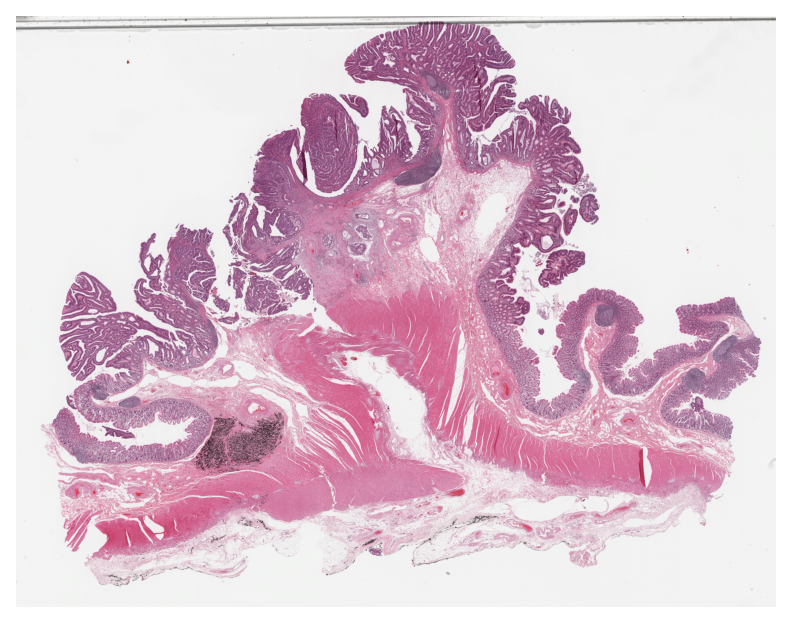

In [ ]:
overview_resolution = (
    4  # the resolution in which we desire to merge and visualize the patch predictions
)
# the unit of the `resolution` parameter. Can be "power", "level", "mpp", or "baseline"
overview_unit = "mpp"
wsi = WSIReader.open(wsi_path)
wsi_overview = wsi.slide_thumbnail(resolution=overview_resolution, units=overview_unit)
plt.figure(), plt.imshow(wsi_overview)
plt.axis("off")

Overlaying the prediction map on this image as below gives:

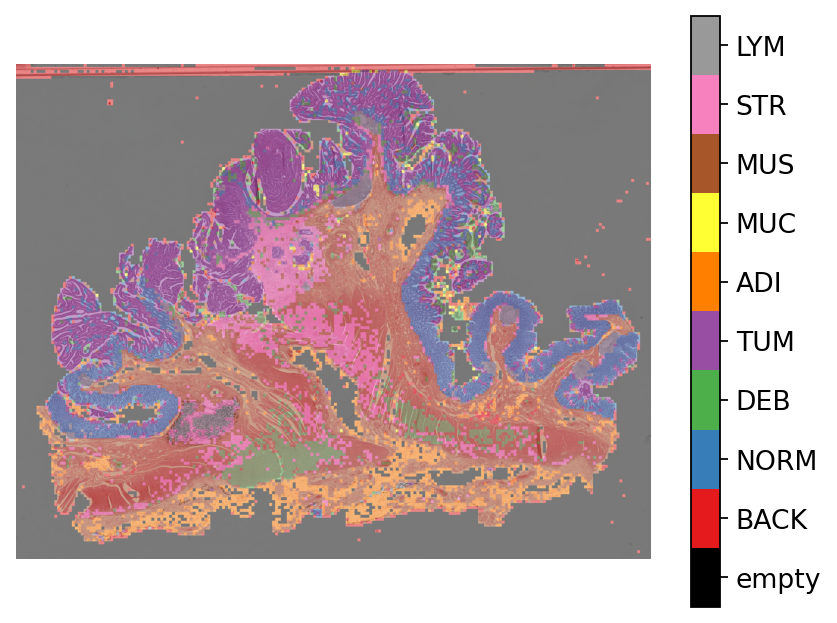

In [ ]:
# Visualization of whole-slide image patch-level prediction
# first set up a label to color mapping
label_color_dict = {}
label_color_dict[0] = ("empty", (0, 0, 0))
colors = cm.get_cmap("Set1").colors
for class_name, label in label_dict.items():
    label_color_dict[label + 1] = (class_name, 255 * np.array(colors[label]))

pred_map = predictor.merge_predictions(
    wsi_path,
    wsi_output[0],
    resolution=overview_resolution,
    units=overview_unit,
)
overlay = overlay_prediction_mask(
    wsi_overview,
    pred_map,
    alpha=0.5,
    label_info=label_color_dict,
    return_ax=True,
)
plt.show()

## Feature extraction with a pathology-specific model

In this section, we will show how to extract features from a pretrained pytorch model that exists outside TIAToolbox, using the WSI inference engines provided by tiatoolbox. To illustrate this we will use HistoEncoder, a computational-pathology specific model that has been trained in a self-supervised fashion to extract features from histology images. The model has been made available here:

'HistoEncoder: Foundation models for digital pathology' (https://github.com/jopo666/HistoEncoder) by Pohjonen, Joona and team at the University of Helsinki.

We will plot a umap reduction into 3D (rgb) of the feature map to visualize how the features capture the differences between some of the above mentioned tissue types.

In [ ]:
# Import some extra modules
import histoencoder.functional as F
import torch.nn as nn

from tiatoolbox.models.engine.semantic_segmentor import DeepFeatureExtractor, IOSegmentorConfig
from tiatoolbox.models.models_abc import ModelABC
import umap

TIAToolbox defines a ModelABC which is a class inheriting PyTorch [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) and specifies how a model should look in order to be used in the TIAToolbox inference engines. The histoencoder model doesn't follow this structure, so we need to wrap it in a class whose output and methods are those that the TIAToolbox engine expects.

In [ ]:
class HistoEncWrapper(ModelABC):
    """Wrapper for HistoEnc model that conforms to tiatoolbox ModelABC interface."""

    def __init__(self: HistoEncWrapper, encoder) -> None:
        super().__init__()
        self.feat_extract = encoder

    def forward(self: HistoEncWrapper, imgs: torch.Tensor) -> torch.Tensor:
        """Pass input data through the model.

        Args:
            imgs (torch.Tensor):
                Model input.

        """
        out = F.extract_features(self.feat_extract, imgs, num_blocks=2, avg_pool=True)
        return out

    @staticmethod
    def infer_batch(
        model: nn.Module,
        batch_data: torch.Tensor,
        *,
        on_gpu: bool,
    ) -> list[np.ndarray]:
        """Run inference on an input batch.

        Contains logic for forward operation as well as i/o aggregation.

        Args:
            model (nn.Module):
                PyTorch defined model.
            batch_data (torch.Tensor):
                A batch of data generated by
                `torch.utils.data.DataLoader`.
            on_gpu (bool):
                Whether to run inference on a GPU.

        """
        img_patches_device = batch_data.to('cuda') if on_gpu else batch_data
        model.eval()
        # Do not compute the gradient (not training)
        with torch.inference_mode():
            output = model(img_patches_device)
        return [output.cpu().numpy()]

Now that we have our wrapper, we will create our feature extraction model and instantiate a [DeepFeatureExtractor](https://tia-toolbox.readthedocs.io/en/v1.4.1/_autosummary/tiatoolbox.models.engine.semantic_segmentor.DeepFeatureExtractor.html) to allow us to use this model over a WSI. We will use the same WSI as above, but this time we will extract features from the patches of the WSI using the HistoEncoder model, rather than predicting some label for each patch.

In [ ]:
# create the model
encoder = F.create_encoder("prostate_medium")
model = HistoEncWrapper(encoder)

# set the pre-processing function
norm=transforms.Normalize(mean=[0.662, 0.446, 0.605],std=[0.169, 0.190, 0.155])
trans = [
    transforms.ToTensor(),
    norm,
]
model.preproc_func = transforms.Compose(trans)

wsi_ioconfig = IOSegmentorConfig(
    input_resolutions=[{"units": "mpp", "resolution": 0.5}],
    patch_input_shape=[224, 224],
    output_resolutions=[{"units": "mpp", "resolution": 0.5}],
    patch_output_shape=[224, 224],
    stride_shape=[224, 224],
)

When we create the `DeepFeatureExtractor`, we will pass the `auto_generate_mask=True` argument. This will automatically create a mask of the tissue region using otsu thresholding, so that the extractor processes only those patches containing tissue.

In [ ]:
# create the feature extractor and run it on the WSI
extractor = DeepFeatureExtractor(model=model, auto_generate_mask=True, batch_size=32, num_loader_workers=4, num_postproc_workers=4)
with suppress_console_output():
    out = extractor.predict(imgs=[wsi_path], mode="wsi", ioconfig=wsi_ioconfig, save_dir=global_save_dir / "wsi_features",)

|2023-11-12|17:50:30.207| [WARNING] Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.
Process Batch: 100%|##########################| 630/630 [02:23<00:00,  4.39it/s]


|2023-11-12|17:52:54.487| [INFO] Finish: 0
|2023-11-12|17:52:54.487| [INFO] --Input: tmp/sample_wsi.svs
|2023-11-12|17:52:54.488| [INFO] --Output: /home/u2271662/tia/projects/tiatoolbox/code/tutorials/intermediate_source/tmp/wsi_features/0


These features could be used to train a downstream model, but here in order to get some intuition for what the features represent, we will use a UMAP reduction to visualize the features in RGB space. The points labeled in a similar color should have similar features, so we can check if the features naturally separate out into the different tissue regions when we overlay the UMAP reduction on the WSI thumbnail. We will plot it along with the patch-level prediction map from above to see how the features compare to the patch-level predictions in the following cells.

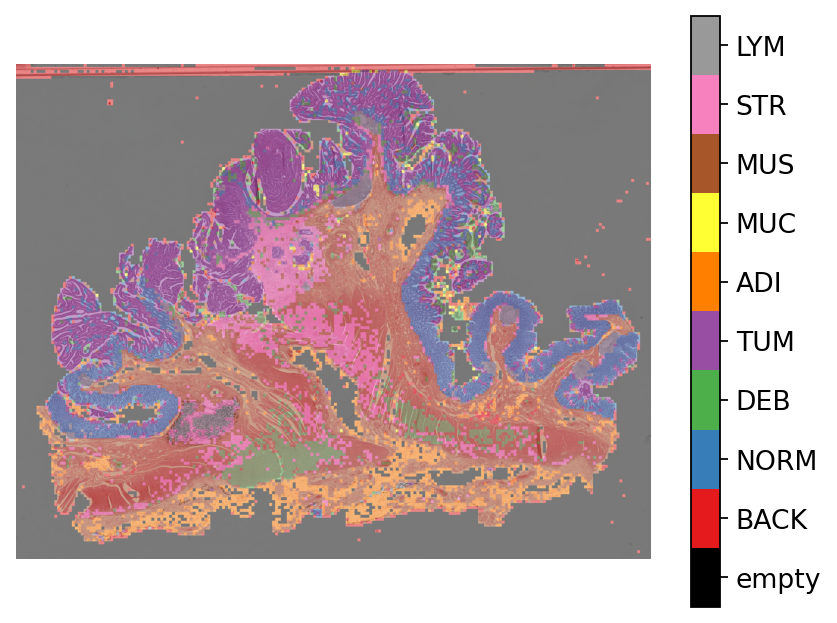

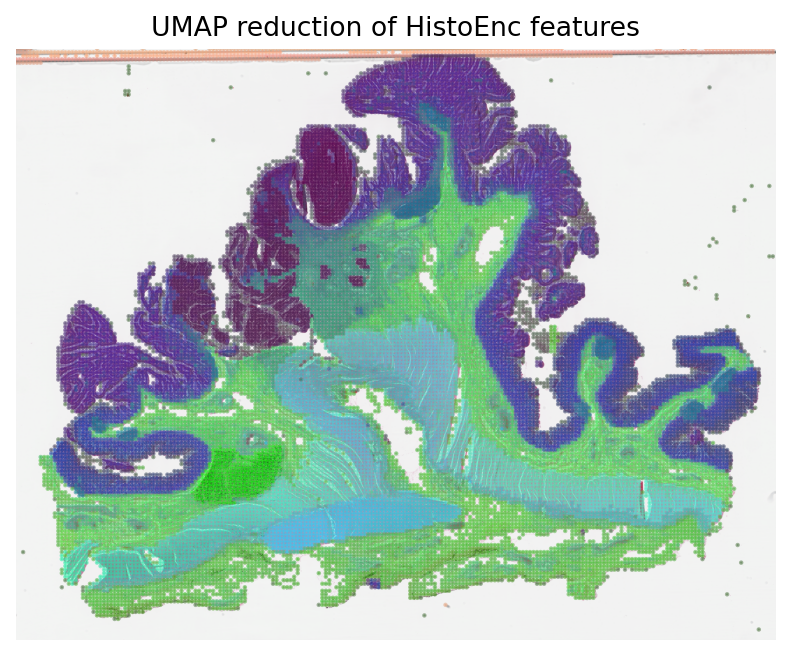

In [ ]:
# First we define a function to calculate the umap reduction
def umap_reducer(x, dims=3, nns=10):
    """UMAP reduction of the input data."""
    reducer = umap.UMAP(n_neighbors=nns, n_components=dims, metric="manhattan", spread=0.5, random_state=2)
    reduced = reducer.fit_transform(x)
    reduced -= reduced.min(axis=0)
    reduced /= reduced.max(axis=0)
    return reduced

# load the features output by our feature extractor
pos = np.load(global_save_dir / "wsi_features" / "0.position.npy")
feats = np.load(global_save_dir / "wsi_features" / "0.features.0.npy")
pos = pos / 8 # as we extracted at 0.5mpp, and we are overlaying on a thumbnail at 4mpp

# reduce the features into 3 dimensional (rgb) space
reduced = umap_reducer(feats)

# plot the prediction map the classifier again
overlay = overlay_prediction_mask(
    wsi_overview,
    pred_map,
    alpha=0.5,
    label_info=label_color_dict,
    return_ax=True,
)

# plot the feature map reduction
plt.figure()
plt.imshow(wsi_overview)
plt.scatter(pos[:,0], pos[:,1], c=reduced, s=1, alpha=0.5)
plt.axis("off")
plt.title("UMAP reduction of HistoEnc features")
plt.show()

We see that the prediction map from our patch-level predictor, and the feature map from our self-supervised feature encoder, capture similar information about the tissue types in the WSI. This is a good sanity check that our models are working as expected. It also shows that the features extracted by the HistoEncoder model are capturing the differences between the tissue types, and so that they are encoding histologically relevant information.

## Where to Go From Here

In this notebook, we show how we can use the `PatchPredictor` and `DeepFeatureExtractor` classes and their `predict` method to predict the label, or extract features, for patches of big tiles and WSIs. We introduce `merge_predictions` and `overlay_prediction_mask` helper functions that merge the patch prediction outputs and visualize the resulting prediction map as an overlay on the input image/WSI.

All the processes take place within TIAToolbox and we can easily put the pieces together, following our example code. Please make sure to set inputs and options correctly. We encourage you to further investigate the effect on the prediction output of changing `predict` function parameters. We have demonstrated how to use your own pretrained model or one provided by the research community for a specific task in the TIAToolbox framework to do inference on large WSIs even if the model structure is not defined in the TIAToolbox model class.

You can learn more through the following resources:

- [Advanced model handling with PyTorch and TIAToolbox](https://tia-toolbox.readthedocs.io/en/latest/_notebooks/jnb/07-advanced-modeling.html)
- [Creating slide graphs for WSI with a custom PyTorch graph neural network](https://tia-toolbox.readthedocs.io/en/latest/_notebooks/jnb/full-pipelines/slide-graph.html)